In [ ]:
import os
import re
from pathlib import Path
import pandas as pd
from collections import defaultdict

# ---------------------------
# Protocol discovery
# ---------------------------
def discover_protocols(base_dir: str):
    """
    Kembalikan dict:
    {
        'p1.1': {'train': path, 'dev': path, 'test': path},
        ...
    }
    """
    proto_dir = Path(base_dir) / "protocol"
    assert proto_dir.exists(), f"Folder protocol tidak ditemukan: {proto_dir}"

    out = defaultdict(dict)
    for f in proto_dir.glob("CASIA_CeFA@*_image_*.txt"):
        m = re.match(r"CASIA_CeFA@(.+?)_image_(train|dev|test)\.txt$", f.name)
        if not m:
            continue
        pid, split = m.groups()
        out[pid][split] = str(f)

    return dict(out)


# ---------------------------
# Helpers
# ---------------------------
def pai_to_label(pai: int) -> int:
    # 1=Real -> 0 (live), 2/3/4 -> 1 (attack)
    return 0 if pai == 1 else 1


def _detect_modality(path_norm: str):
    low = path_norm.lower()

    # folder mana pun (awal/tengah)
    if re.search(r'(^|/)color(/|$)', low) or re.search(r'(^|/)rgb(/|$)', low):
        return 'color'
    if re.search(r'(^|/)ir(/|$)', low):
        return 'ir'
    if re.search(r'(^|/)depth(/|$)|(^|/)dpt(/|$)', low):
        return 'depth'

    # fallback: dari filename
    fname = os.path.basename(low)
    if 'color' in fname or 'rgb' in fname:
        return 'color'
    if 'depth' in fname or 'dpt' in fname:
        return 'depth'
    if 'ir' in fname:
        return 'ir'

    return None


def _group_key_without_first_mod(path_norm: str):
    """
    Buang 1x segmen /color|ir|depth/ di path
    untuk menyatukan frame antar modalitas.
    Key: (parent_path_no_mod, stem)
    """
    cleaned = re.sub(
        r'/(color|ir|depth)(/|$)', '/',
        path_norm, count=1, flags=re.IGNORECASE
    )
    parent = os.path.dirname(cleaned)
    stem = os.path.splitext(os.path.basename(cleaned))[0]
    return parent, stem


def _try_parse_pai_from_seq(path_norm: str):
    # cari pola .../<d>_<ddd>_<d>_<d>_<d>/...
    m = re.search(r'/(\d)_(\d{3})_(\d)_(\d)_(\d)/', path_norm)
    if m:
        # token ke-4 = PAI (sering dipakai di CeFA)
        return int(m.group(4))
    return None


def _parse_protocol_line(line: str):
    """
    Format umum:
    1) <rel_path> <label> (label 0/1) --> label langsung dipakai
    2) <rel_path> <pai> (pai 1..4) --> dikonversi lewat pai_to_label
    3) <rel_path> (tanpa angka) --> derive dari PAI di path
    """
    s = line.strip()
    if not s or s.startswith('#'):
        return None, None

    parts = s.split()
    label = None

    if len(parts) >= 2 and parts[-1].isdigit():
        last = int(parts[-1])
        path = ' '.join(parts[:-1])
        if last in (0, 1):
            label = last
        elif 1 <= last <= 4:
            label = pai_to_label(last)
    else:
        path = s

    path = path.replace('\\', '/').lstrip('./')
    return path, label


# ---------------------------
# Build DF dari satu file protocol
# ---------------------------
def build_cefa_from_protocol(base_dir: str, protocol_txt: str) -> pd.DataFrame:
    base = Path(base_dir)
    proto = Path(protocol_txt)
    assert proto.exists(), f"Protocol file tidak ditemukan: {proto}"

    groups = defaultdict(list)  # key -> list of buckets
    # key -> {'color','ir','depth','label'}

    with open(proto, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f:
            rel, label = _parse_protocol_line(raw)
            if rel is None:
                continue

            rel_norm = rel.replace('\\', '/')
            mod = _detect_modality(rel_norm)

            if label is None:
                pai = _try_parse_pai_from_seq(rel_norm)
                if pai is not None:
                    label = pai_to_label(pai)

            key = _group_key_without_first_mod(rel_norm)
            bucket = {'color': None, 'ir': None, 'depth': None, 'label': None}
            if mod in ('color','ir','depth'):
                bucket[mod] = rel_norm
            if label is not None:
                bucket['label'] = int(label)
            groups[key].append(bucket)


    rows = []
    for key, bucket_list in groups.items():
        for v in bucket_list:
            if v['label'] is None:
                pai = _try_parse_pai_from_seq(
                    v['color'] or v['ir'] or v['depth'] or ''
                )
                v['label'] = pai_to_label(pai) if pai is not None else 1
            rows.append({
                'color_file': v['color'],
                'ir_file': v['ir'],
                'depth_file': v['depth'],
                'label': v['label'],
            })

    return pd.DataFrame(rows).reset_index(drop=True)


# ---------------------------
# Swap modality (helper tambahan)
# ---------------------------
def _swap_mod_once(path_rel: str, to_mod: str) -> str:
    """
    Ganti 1x segmen folder modality di path relatif:
    .../color/0001.jpg -> .../ir/0001.jpg (atau depth)

    Sekaligus coba rename prefix filename:
    color_0001.jpg -> ir_0001.jpg
    """
    if not isinstance(path_rel, str):
        return None

    s = path_rel.replace('\\', '/')

    # ganti folder modality pertama yang ketemu
    s = re.sub(
        r'/(color|rgb|ir|depth)(/|$)',
        f'/{to_mod}/', s, count=1, flags=re.IGNORECASE
    )

    # ganti prefix nama file 'color'/'rgb' -> target
    base, fname = os.path.split(s)
    fname2 = re.sub(
        r'(^|[-_])(color|rgb)', r'\1' + to_mod,
        fname, flags=re.IGNORECASE
    )

    if fname2 != fname:
        s = os.path.join(base, fname2).replace('\\', '/')

    return s


def duplicate_color_to_ir_depth(df: pd.DataFrame) -> pd.DataFrame:
    """
    Isi kolom ir_file & depth_file DARI color_file
    dengan swap folder/prefix.
    Tidak mengecek keberadaan file (sesuai permintaan).
    """
    df = df.copy()

    # kalau kolom belum ada, buat dulu
    if 'ir_file' not in df.columns:
        df['ir_file'] = None
    if 'depth_file' not in df.columns:
        df['depth_file'] = None

    # hanya isi baris yang masih None/NaN
    mask_ir = df['ir_file'].isna() | df['ir_file'].isnull()
    mask_dpth = df['depth_file'].isna() | df['depth_file'].isnull()

    df.loc[mask_ir, 'ir_file'] = df.loc[mask_ir, 'color_file'].apply(
        lambda p: _swap_mod_once(p, 'ir')
    )
    df.loc[mask_dpth, 'depth_file'] = df.loc[mask_dpth, 'color_file'].apply(
        lambda p: _swap_mod_once(p, 'depth')
    )

    return df


# ---------------------------
# Load 1..N protocol sekaligus
# ---------------------------
def load_cefa_protocols(base_dir: str, protocols='all'):
    """
    Return: (df_train, df_dev, df_test) hasil CONCAT dari protocol terpilih.

    protocols:
        'all' | 'p1.1' | ['p1.1','p1.3',...]
    """
    found = discover_protocols(base_dir)

    if protocols == 'all':
        keys = sorted(found.keys())
    elif isinstance(protocols, str):
        keys = [protocols]
    else:
        keys = list(protocols)

    miss = [k for k in keys if k not in found]
    assert not miss, f"Protocol tidak ditemukan: {miss}. Tersedia: {sorted(found.keys())}"

    dfs = {'train': [], 'dev': [], 'test': []}

    for k in keys:
        paths = found[k]
        for split in ('train', 'dev', 'test'):
            if split not in paths:
                continue

            df = build_cefa_from_protocol(base_dir, paths[split])
            df['protocol'] = k

            # [ADD] — DUPLIKASI COLOR → IR/DEPTH (tanpa cek file)
            df = duplicate_color_to_ir_depth(df)

            dfs[split].append(df)

    df_train = pd.concat(dfs['train'], ignore_index=True) if dfs['train'] \
        else pd.DataFrame(columns=['color_file', 'ir_file', 'depth_file', 'label'])
    df_dev = pd.concat(dfs['dev'], ignore_index=True) if dfs['dev'] \
        else pd.DataFrame(columns=['color_file', 'ir_file', 'depth_file', 'label'])
    df_test = pd.concat(dfs['test'], ignore_index=True) if dfs['test'] \
        else pd.DataFrame(columns=['color_file', 'ir_file', 'depth_file', 'label'])



    for split_name, df in [('train', df_train), ('dev', df_dev), ('test', df_test)]:
        print(split_name, 'size=', len(df))
        print('label counts:', df['label'].value_counts(dropna=False).to_dict())
        print('missing rgb/ir/depth:',
          df['color_file'].isna().mean(),
          df['ir_file'].isna().mean(),
          df['depth_file'].isna().mean())
    return df_train, df_dev, df_test


augment

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import os


class CeFA_MultiModalDataset(Dataset):
    def __init__(
        self,
        df,
        base_dir,
        img_size=(112, 112),
        train=True,
        normalize=True,
        rgb_mean=(0.485, 0.456, 0.406),
        rgb_std=(0.229, 0.224, 0.225),
        ir_mean=(0.5, 0.5, 0.5),
        ir_std=(0.5, 0.5, 0.5),
        depth_mean=(0.5, 0.5, 0.5),
        depth_std=(0.5, 0.5, 0.5),
        load_images=True,
    ):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.img_size = img_size
        self.train = train
        self.normalize = normalize
        self.load_images = load_images

        # transform ops (dipakai hanya kalau load_images=True)
        self.resize = transforms.Resize(img_size, antialias=True)
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
        # self.color_jitter = transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)

        if normalize:
            self.norm_rgb = transforms.Normalize(rgb_mean, rgb_std)
            self.norm_ir = transforms.Normalize(ir_mean, ir_std)
            self.norm_depth = transforms.Normalize(depth_mean, depth_std)

    def __len__(self):
        return len(self.df)

    def _resolve_path(self, rel):
        if rel is None:
            return None
        return os.path.join(os.path.split(self.base_dir)[0], rel)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        rgb_path = self._resolve_path(r['color_file'])
        ir_path = self._resolve_path(r['ir_file'])
        depth_path = self._resolve_path(r['depth_file'])
        label = torch.tensor(r['label'], dtype=torch.float32)

        # derive video_id dari path color_file
        rel_path = r['color_file'].replace("\\", "/")
        video_id = "/".join(rel_path.split("/")[:-2])

        # === CASE 1: hanya return path (no image load)
        if not self.load_images:
            return {'rgb': rgb_path, 'ir': ir_path, 'depth': depth_path}, label, video_id

        # === CASE 2: load image normal ===
        def _open(path, prefer_rgb=True):
            if path is None:
                return None
            try:
                img = Image.open(path)
                img = img.convert('RGB') if prefer_rgb else img.convert('L')
                return img
            except Exception:
                return None

        rgb = _open(rgb_path, prefer_rgb=True)
        ir = _open(ir_path, prefer_rgb=False)
        depth = _open(depth_path, prefer_rgb=False)

        # resize
        if rgb is not None:
            rgb = self.resize(rgb)
        if ir is not None:
            ir = self.resize(ir)
        if depth is not None:
            depth = self.resize(depth)


         # augmentasi (hanya jika train)
#         if self.train:
#             # horizontal flip
#             if random.random() < 0.5:
#                 if rgb is not None:
#                     rgb = transforms.functional.hflip(rgb)
#                 if ir is not None:
#                     ir = transforms.functional.hflip(ir)
#                 if depth is not None:
#                     depth = transforms.functional.hflip(depth)

#             # augmentasi tambahan untuk RGB
#             if rgb is not None:
#                 if random.random() < 0.5:
#                     rgb = self.random_crop(rgb)
#                 if random.random() < 0.3:
#                     rgb = self.random_rotation(rgb)
#                 rgb = self.color_jitter(rgb)
#                 if random.random() < 0.2:
#                     rgb = self.random_gray(rgb)
        # augment
        # if self.train and random.random() < 0.8:
        if self.train and random.random() < 0.5:
            if rgb is not None:
                rgb = transforms.functional.hflip(rgb)
            if ir is not None:
                ir = transforms.functional.hflip(ir)
            if depth is not None:
                depth = transforms.functional.hflip(depth)
            angle = random.random() * 60 - 30
            if rgb is not None:
                rgb = transforms.functional.rotate(rgb, angle)
            if ir is not None:
                ir = transforms.functional.rotate(ir, angle)
            if depth is not None:
                depth = transforms.functional.rotate(depth, angle)

        if self.train and rgb is not None:
            rgb = self.color_jitter(rgb)

        def to3(img):
            if img is None:
                return None
            return img if img.mode == 'RGB' else Image.merge('RGB', (img, img, img))

        ir, depth = to3(ir), to3(depth)

        C, H, W = 3, self.img_size[0], self.img_size[1]
        zeros = torch.zeros(C, H, W)

        rgb_t = self.to_tensor(rgb) if rgb is not None else zeros
        ir_t = self.to_tensor(ir) if ir is not None else zeros
        depth_t = self.to_tensor(depth) if depth is not None else zeros

        rgb_t = rgb_t * 2.0 - 1.0
        ir_t = ir_t * 2.0 - 1.0
        depth_t = depth_t * 2.0 - 1.0

        if self.normalize:
            rgb_t = self.norm_rgb(rgb_t)
            ir_t = self.norm_ir(ir_t)
            depth_t = self.norm_depth(depth_t)

        return {'rgb': rgb_t, 'ir': ir_t, 'depth': depth_t}, label, video_id


In [ ]:
# DataLoader (gaya CASIA-SURF)
from torch.utils.data import DataLoader
BATCH_SIZE = 128

# Root yang memuat: Ethnicity/, Mask/, protocol/
# base_dir_cefa = r"E:\BaiduNetdiskDownload\CASIA_CeFA"
base_dir_cefa = r"F:\Dataset_Fas\CASIA_CeFA"

# Lihat semua protocol yang tersedia
avail = discover_protocols(base_dir_cefa)
print("Available protocols:", sorted(avail.keys()))

# Contoh 1: hanya p1.1
# df_train, df_dev, df_test = load_cefa_protocols(base_dir_cefa, 'p1.1')

# Contoh 2: gabungan p1.1 + p1.3 + p1.5
df_train, df_dev, df_test = load_cefa_protocols(base_dir_cefa, [('p4.1'), ('p4.3'), ('p4.5')])
# df_train, df_dev, df_test = load_cefa_protocols(base_dir_cefa, ['p4.5'])

# # Contoh 3: pakai semua protocol
# df_train, df_dev, df_test = load_cefa_protocols(base_dir_cefa, 'all')

print("Used protocols:", sorted(df_train['protocol'].unique()))

# Sampling 10 item: pastikan benar2 bisa dibuka dan ukurannya cocok
ds_dbg = CeFA_MultiModalDataset(df_train.sample(10, random_state=0), base_dir_cefa, train=False)
ok_rgb = ok_ir = ok_depth = 0
for i in range(len(ds_dbg)):
    x,_,_ = ds_dbg[i]
    ok_rgb   += int(x['rgb'].abs().sum().item() > 0)
    ok_ir    += int(x['ir'].abs().sum().item() > 0)
    ok_depth += int(x['depth'].abs().sum().item() > 0)
print('opened tensors (non-zero):', ok_rgb, ok_ir, ok_depth)

dbg = CeFA_MultiModalDataset(df_train.sample(16, random_state=0), base_dir_cefa, train=False)
nz = {'rgb':0,'ir':0,'depth':0}
for i in range(len(dbg)):
    x,_,_ = dbg[i]
    for k in nz: nz[k] += int(x[k].abs().sum().item() > 0)
print('opened_nonzero:', nz)


train_ds = CeFA_MultiModalDataset(df_train, base_dir_cefa, train=True, img_size=(112,112), load_images=True, normalize=False)
# val_ds   = CeFA_MultiModalDataset(df_dev,   base_dir_cefa, train=False, img_size=(112,112))
test_ds  = CeFA_MultiModalDataset(df_test,  base_dir_cefa, train=False, img_size=(112,112), load_images=True, normalize=False)

pin = torch.cuda.is_available()
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers= 0,  # 4–8 biasanya aman
    pin_memory= True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers= 0,
    pin_memory= True,
)
# val_loader = DataLoader(
#     val_ds,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers= 0,
#     pin_memory= pin,
# )



Available protocols: ['p1.1', 'p1.3', 'p1.5', 'p2.1', 'p2.2', 'p3', 'p4.1', 'p4.3', 'p4.5']
train size= 109632
label counts: {0: 58964, 1: 50668}
missing rgb/ir/depth: 0.0 0.0 0.0
dev size= 56070
label counts: {0: 29223, 1: 26847}
missing rgb/ir/depth: 0.0 0.0 0.0
test size= 462614
label counts: {1: 345700, 0: 116914}
missing rgb/ir/depth: 0.0 0.0 0.0
Used protocols: ['p4.1', 'p4.3', 'p4.5']
opened tensors (non-zero): 10 10 10
opened_nonzero: {'rgb': 16, 'ir': 16, 'depth': 16}


In [ ]:
# # Smoke test
# xb, yb = next(iter(train_loader))
# print(xb.keys(), xb['rgb'].shape, yb.shape)

xb, yb, vids = next(iter(train_loader))
print(xb.keys(), xb['rgb'].shape, yb.shape, len(vids))


dict_keys(['rgb', 'ir', 'depth']) torch.Size([128, 3, 112, 112]) torch.Size([128]) 128


In [ ]:
for batch in train_loader:
    x, y, vids = batch
    for k,v in x.items():
        print(k, v.min().item(), v.max().item())
        print(k, v.shape)
    break


rgb -1.0 1.0
rgb torch.Size([128, 3, 112, 112])
ir -1.0 1.0
ir torch.Size([128, 3, 112, 112])
depth -1.0 1.0
depth torch.Size([128, 3, 112, 112])


# INI JANGAN DI RUN KALAU LOAD IMAGES

In [ ]:
#jgn run kalo load image

print(train_loader.dataset.df.shape)
print(test_loader.dataset.df.shape)


xb, yb, vids = next(iter(train_loader))
print("Batch size:", len(vids))
print("Unique videos in this batch:", len(set(vids)))

all_vids, all_labels = [], []
for _, yb, vids in train_loader:
    all_vids.extend(list(vids))
    all_labels.extend(list(yb.numpy()))

df = pd.DataFrame({'vid': all_vids, 'label': all_labels})

print("\nTrain Data")
print("Total frames:", len(all_vids))
print("Total unique videos:", len(set(all_vids)))
print("Unique videos total:", df['vid'].nunique())
print("Unique videos live :", df[df['label']==0]['vid'].nunique())
print("Unique videos fake :", df[df['label']==1]['vid'].nunique())


all_vids, all_labels = [], []
for _, yb, vids in test_loader:
    all_vids.extend(list(vids))
    all_labels.extend(list(yb.numpy()))

df = pd.DataFrame({'vid': all_vids, 'label': all_labels})
print("\nTest Data")
print("Total frames:", len(all_vids))
print("Total unique videos:", len(set(all_vids)))
print("Unique videos total:", df['vid'].nunique())
print("Unique videos live :", df[df['label']==0]['vid'].nunique())
print("Unique videos fake :", df[df['label']==1]['vid'].nunique())


(109632, 5)
(462614, 5)



KeyboardInterrupt



In [ ]:
df_test

# **ResNet18 CA**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# --------- Backbone (tanpa maxpool, sampai layer3) ---------
class Backbone(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        layers = list(base.children())
        self.feature_extractor = nn.Sequential(
            layers[0],  # conv1        -> [B,64,H/2,W/2]
            layers[1],  # bn1
            layers[2],  # relu
            layers[3],  # maxpool
            layers[4],  # layer1       -> [B,64, H/2, W/2]
            layers[5],  # layer2       -> [B,128,H/4, W/4]
            layers[6],  # layer3       -> [B,256,H/8, W/8]
        )
        self.proj = nn.Conv2d(256, embed_dim, kernel_size=1)

    def forward(self, x):
        x = self.feature_extractor(x)          # [B,256,H/8,W/8]
        h, w = x.shape[-2], x.shape[-1]
        x = self.proj(x)                       # [B,256,H/8,W/8] (E=256)
        x_tokens = x.flatten(2).transpose(1, 2)  # [B, S, E], S=(H/8)*(W/8)
        return x_tokens, (h, w)                # kembalikan juga ukuran spasial


# --------- Cross-Attention Block (batch_first biar rapi) ---------
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # query/key_value: [B, S, E]
        out, _ = self.attn(query, key_value, key_value)  # [B, S, E]
        out = self.ln(out + query)                       # residual + LN (Post-LN)
        return out


# --------- Flexible Multi-Path Fusion (pooling SETELAH CA) ---------
class FlexibleMultiPathFusionModel(nn.Module):
    def __init__(self, backbone_cls, embed_dim=256, num_heads=8, fusion_type='add'):
        """
        backbone_cls: class backbone untuk semua modalitas (harus terima argumen embed_dim).
        fusion_type: 'concat' atau 'add'. (Concat akan diproyeksikan kembali ke dim embed_dim)
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.fusion_type = fusion_type

        # Backbone per modality (samakan embed_dim=256)
        self.rgb_backbone   = backbone_cls(embed_dim=embed_dim)
        self.depth_backbone = backbone_cls(embed_dim=embed_dim)
        self.ir_backbone    = backbone_cls(embed_dim=embed_dim)

        # Cross Attention untuk semua pasangan (bidirectional)
        self.ca_rgb_depth = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_depth_rgb = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_rgb_ir    = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_ir_rgb    = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_depth_ir  = CrossAttentionBlock(embed_dim, num_heads)
        self.ca_ir_depth  = CrossAttentionBlock(embed_dim, num_heads)

        # Gating weights (learnable)
        self.gate = nn.Parameter(torch.ones(6))  # 6 arah pasangan

        # Proyeksi jika concat (6 * E -> E), agar classifier tetap Linear(E,1)
        if fusion_type == 'concat':
            self.fusion_proj = nn.Linear(6 * embed_dim, embed_dim)

        # Classifier
        self.classifier = nn.Linear(embed_dim, 1)

    @staticmethod
    def _pool_after_ca(y, hw):
        """y: [B, S, E], hw=(H,W) -> pooling spasial ke [B, E]"""
        B, S, E = y.shape
        H, W = hw
        feat = y.transpose(1, 2).reshape(B, E, H, W)         # [B,E,H,W]
        pooled = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # [B,E]
        return pooled

    def forward(self, rgb=None, depth=None, ir=None):
        hw = None

        if rgb is not None:
            rgb_feat, hw = self.rgb_backbone(rgb)
        else:
            rgb_feat = None

        if depth is not None:
            depth_feat, hw_d = self.depth_backbone(depth)
            if hw is None:
                hw = hw_d
        else:
            depth_feat = None

        if ir is not None:
            ir_feat, hw_i = self.ir_backbone(ir)
            if hw is None:
                hw = hw_i
        else:
            ir_feat = None

        if hw is None:
            raise ValueError("Minimal satu modalitas harus ada untuk dapatkan (H,W)")

        # Siapkan dummy jika modalitas None (panjang S & E harus konsisten)
        if rgb_feat is None:
            B, S, E = depth_feat.shape if depth_feat is not None else ir_feat.shape
            dev = depth.device if depth is not None else ir.device
            rgb_feat = torch.zeros((B, S, E), device=dev)

        if depth_feat is None:
            B, S, E = rgb_feat.shape
            dev = rgb.device if rgb is not None else ir.device
            depth_feat = torch.zeros((B, S, E), device=dev)

        if ir_feat is None:
            B, S, E = rgb_feat.shape
            dev = rgb.device if rgb is not None else depth.device
            ir_feat = torch.zeros((B, S, E), device=dev)

        # Bidirectional Cross Attention (di resolusi token tinggi)
        y_rgb_depth = self.ca_rgb_depth(rgb_feat,   depth_feat)  # [B,S,E]
        y_depth_rgb = self.ca_depth_rgb(depth_feat, rgb_feat)
        y_rgb_ir    = self.ca_rgb_ir(rgb_feat,      ir_feat)
        y_ir_rgb    = self.ca_ir_rgb(ir_feat,       rgb_feat)
        y_depth_ir  = self.ca_depth_ir(depth_feat,  ir_feat)
        y_ir_depth  = self.ca_ir_depth(ir_feat,     depth_feat)

        # Pooling SETELAH CA -> masing-masing jadi [B,E]
        y_rgb_depth_p = self._pool_after_ca(y_rgb_depth, hw)
        y_depth_rgb_p = self._pool_after_ca(y_depth_rgb, hw)
        y_rgb_ir_p    = self._pool_after_ca(y_rgb_ir,    hw)
        y_ir_rgb_p    = self._pool_after_ca(y_ir_rgb,    hw)
        y_depth_ir_p  = self._pool_after_ca(y_depth_ir,  hw)
        y_ir_depth_p  = self._pool_after_ca(y_ir_depth,  hw)

        # Mask & gating
        with torch.no_grad():
            m_rgb   = (rgb_feat.abs().sum()   > 0).float()
            m_depth = (depth_feat.abs().sum() > 0).float()
            m_ir    = (ir_feat.abs().sum()    > 0).float()
        mask = torch.stack([m_depth, m_rgb, m_ir, m_rgb, m_ir, m_depth])  # urut sesuai pasangan
        gates = torch.sigmoid(self.gate) * mask  # [6]

        # Fusion di ruang vektor [B,E] (setelah pooling)
        if self.fusion_type == 'concat':
            fusion_vec = torch.cat([
                gates[0] * y_rgb_depth_p,
                gates[1] * y_depth_rgb_p,
                gates[2] * y_rgb_ir_p,
                gates[3] * y_ir_rgb_p,
                gates[4] * y_depth_ir_p,
                gates[5] * y_ir_depth_p,
            ], dim=1)                              # [B, 6E]
            fusion_vec = self.fusion_proj(fusion_vec)  # [B, E]
        else:  # 'add'
            fusion_vec = (
                gates[0] * y_rgb_depth_p +
                gates[1] * y_depth_rgb_p +
                gates[2] * y_rgb_ir_p   +
                gates[3] * y_ir_rgb_p   +
                gates[4] * y_depth_ir_p +
                gates[5] * y_ir_depth_p
            )  # [B, E]

        logits = self.classifier(fusion_vec)  # [B,1]
        return logits


***SETUP MODEL***

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = FlexibleMultiPathFusionModel(backbone_cls=Backbone, embed_dim=256, num_heads=8, fusion_type='add').to(device)

cuda


# Kalau mau lanjut epoch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# === Konfigurasi ===
OUTPUT_PATH = r"E:\model_krisna\cefa"
os.makedirs(OUTPUT_PATH, exist_ok=True)
OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_CEFA_Protocol4_36.pth") #load kalo mau lnjut

RESUME_TRAINING = True   # ubah ke False kalau mau mulai dari awal"
NUM_EPOCHS = 13

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.338))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)

start_epoch = 0
best_val_loss = float("inf")
best_val_acer = float("inf")

# === Load checkpoint kalau resume ===
if RESUME_TRAINING and os.path.exists(OUTPUT_MODEL_PATH_LOCAL):
    checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]

    print(f"✅ Model dilanjutkan dari epoch {start_epoch}")
else:
    print("⚡ Mulai training dari awal.")

# === Training loop ===
for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                desc=f"Epoch [{epoch+1}]", leave=True)

    for i, (x, y, _) in pbar:
        rgb = x['rgb'].to(device)
        depth = x['depth'].to(device)
        ir = x['ir'].to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(rgb, depth, ir)  # logits
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y.size(0)
        pbar.set_postfix({"BatchLoss": f"{loss.item():.6f}"})

    avg_loss = train_loss / len(train_loader.dataset)
    print(f" ✅ Epoch [{epoch}] - Train Loss: {avg_loss:.6f}")

    # === Save checkpoint tiap epoch ===
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
    }

    #save model per epoch

    OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_CEFA_Protocol4_37_50.pth") #lupa rename
    torch.save(checkpoint, OUTPUT_MODEL_PATH_LOCAL)
    print(f"💾 Checkpoint disimpan: {OUTPUT_MODEL_PATH_LOCAL}")


C:\Users\Songket\AppData\Local\Temp\ipykernel_21864\3412036517.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_loca

✅ Model dilanjutkan dari epoch 37


Epoch [38]:  66%|███████████████████████████████▊                | 567/857 [34:30<17:38,  3.65s/it, BatchLoss=0.000000]


KeyboardInterrupt: 

In [ ]:
# OUTPUT_PATH = "E:\model_krisna" #4060
# OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_SURF_50_NoBCE.pth")
# checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])

OUTPUT_PATH = r"E:\model_krisna\CEFA" #4060
OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_CEFA_Protocol4_36.pth")
checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# OUTPUT_PATH = "E:/model_krisna/ablasi" #4060
# OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_Best.pth")
# checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_location=device)
# # model.load_state_dict(checkpoint["model_state_dict"])
# model.load_state_dict(checkpoint)

C:\Users\Songket\AppData\Local\Temp\ipykernel_21864\160102216.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_locati

<All keys matched successfully>

Evaluating (per frame): 100%|████████████████████████████████████████████████████| 3615/3615 [1:17:28<00:00,  1.29s/it]



--- Per-Video (Mean) ---
Optimal Threshold: -21.518813
AUC: 0.998770
Accuracy: 0.984947, F1: 0.990468
APCER: 0.015928, BPCER: 0.011667, ACER: 0.013797


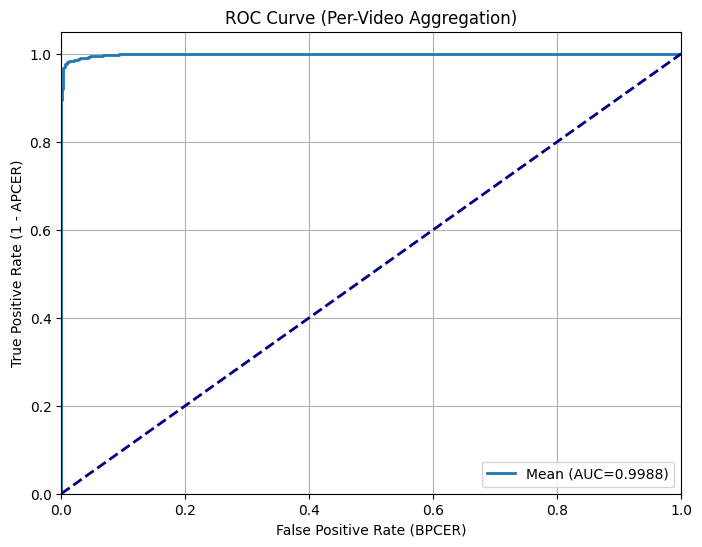

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import torch
import json   # <=== tambahan

# ======================
# Fungsi Metrik
# ======================
def find_best_acer_and_metrics(y_true, y_pred_scores):
    """
    Cari threshold optimal (ACER minimum).
    Asumsi: SPOOF = 1 (positif), REAL = 0 (negatif).
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores, pos_label=1)

    apcer = 1 - tpr   # spoof salah jadi real
    bpcer = fpr       # real salah jadi spoof
    acer  = (apcer + bpcer) / 2.0

    best_idx = np.argmin(acer)
    best_acer = acer[best_idx]
    best_apcer = apcer[best_idx]
    best_bpcer = bpcer[best_idx]
    best_threshold = thresholds[best_idx]

    roc_auc = auc(fpr, tpr)

    # confusion matrix di threshold terbaik
    y_pred_binary = (y_pred_scores >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    metrics = {
        'ACER': best_acer,
        'APCER': best_apcer,
        'BPCER': best_bpcer,
        'Optimal_Threshold': best_threshold,
        'AUC': roc_auc,
        'Accuracy_at_Best_ACER': acc,
        'F1_Score_at_Best_ACER': f1,
        'roc_curve_data': {
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist()
        }
    }

    # === tambahan: buat JSON-friendly ===
    serializable_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, np.generic):
            serializable_metrics[key] = value.item()
        else:
            serializable_metrics[key] = value

    return serializable_metrics


# ======================
# Evaluasi Per Video
# ======================
model.eval()
all_video_scores = {}
all_video_labels = {}

from collections import defaultdict

all_video_scores = defaultdict(list)
all_video_labels = defaultdict(list)

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Evaluating (per frame)", leave=True)
    for x, y, video_ids in pbar:
        rgb   = x['rgb'].to(device)
        ir    = x['ir'].to(device)
        depth = x['depth'].to(device)

        preds = model(rgb=rgb, depth=depth, ir=ir).view(-1).cpu().numpy()

        labels = y.view(-1).cpu().numpy()

        for vid, score, label in zip(video_ids, preds, labels):
            vid = str(vid)
            all_video_scores[vid].append(float(score))
            all_video_labels[vid].append(int(label))   # <=== simpan semua frame label

# ======================
# Agregasi Skor Per Video
# ======================
video_ids_sorted = sorted(all_video_scores.keys())
video_labels = []
for vid in video_ids_sorted:
    labels = all_video_labels[vid]
    if len(set(labels)) > 1:
        print(f"[WARNING] Video {vid} punya label campuran: {set(labels)}")
    # default: ambil mayoritas
    label = int(np.round(np.mean(labels)))
    video_labels.append(label)

video_labels = np.array(video_labels)
video_scores_mean = np.array([np.mean(all_video_scores[vid]) for vid in video_ids_sorted])

# ======================
# Fungsi Evaluasi + Print
# ======================
def evaluate_video_level(y_true, y_scores, method_name="Mean"):
    metrics = find_best_acer_and_metrics(y_true, y_scores)

    print(f"\n--- Per-Video ({method_name}) ---")
    print(f"Optimal Threshold: {metrics['Optimal_Threshold']:.6f}")
    print(f"AUC: {metrics['AUC']:.6f}")
    print(f"Accuracy: {metrics['Accuracy_at_Best_ACER']:.6f}, F1: {metrics['F1_Score_at_Best_ACER']:.6f}")
    print(f"APCER: {metrics['APCER']:.6f}, BPCER: {metrics['BPCER']:.6f}, ACER: {metrics['ACER']:.6f}")

    return metrics
# ======================
# Evaluasi Semua Agregasi
# ======================
res_mean = evaluate_video_level(video_labels, video_scores_mean, "Mean")

# ======================
# Plot ROC Curve Gabungan
# ======================
plt.figure(figsize=(8, 6))

# Mean
roc_data = res_mean['roc_curve_data']
plt.plot(roc_data['fpr'], roc_data['tpr'], lw=2,
         label=f"Mean (AUC={res_mean['AUC']:.4f})")
# Garis baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (BPCER)')
plt.ylabel('True Positive Rate (1 - APCER)')
plt.title('ROC Curve (Per-Video Aggregation)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import os
import json
from pathlib import Path
from IPython.display import FileLink # Import FileLink

# Path folder Downloads user
downloads_folder = Path.home() / "Downloads"
downloads_folder.mkdir(exist_ok=True)  # pastikan folder ada

# Nama file output
# OUTPUT_PATH = "D:/Krisna/MODELS/ResNet18/"
OUTPUT_PATH = "E:\model_krisna\cefa" #4060
# checkpoint = {
#     "epoch": epoch + 1,
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     "loss": avg_loss,
# }


OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_ResNet18_LF_Add_CAPool_Protocol4_20_Augment.pth")
OUTPUT_JSON_PATH_LOCAL = os.path.join(OUTPUT_PATH, "Eval_Result_CA_CEFA_Protocol4_36.json")


# Simpan file pth
# torch.save(checkpoint, OUTPUT_MODEL_PATH_LOCAL)
# torch.save(model.state_dict(), OUTPUT_MODEL_PATH_LOCAL)
# print(f"✅ Model tersimpan di: {OUTPUT_MODEL_PATH_LOCAL}")

# Simpan file JSON
with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
    json.dump(res_mean, f, indent=4)  # Ganti 'metrics' dengan 'res_mean'

print(f"✅ Hasil evaluasi tersimpan di: {OUTPUT_JSON_PATH_LOCAL}")

# --- Tampilkan hasil di konsol ---
print("\n--- Hasil Evaluasi ---")
for key, value in res_mean.items():  # Ganti 'metrics' dengan 'res_mean'
    if key != 'roc_curve_data':
        # Format angka jika float
        if isinstance(value, float):
            print(f"{key}: {value:.6f}")
        else:
            print(f"{key}: {value}")
print("------------------------\n")

# Simpan ke file JSON di local Colab session
os.makedirs(os.path.dirname(OUTPUT_JSON_PATH_LOCAL), exist_ok=True)
with open(OUTPUT_JSON_PATH_LOCAL, 'w') as f:
    json.dump(res_mean, f, indent=4)  # Ganti 'metrics' dengan 'res_mean'
print(f"✅ Hasil evaluasi berhasil disimpan di: {OUTPUT_JSON_PATH_LOCAL}")

FileLink(OUTPUT_JSON_PATH_LOCAL)  # klik link yang muncul untuk download



✅ Hasil evaluasi tersimpan di: E:\model_krisna\cefa\Eval_Result_CA_CEFA_Protocol4_36.json

--- Hasil Evaluasi ---
ACER: 0.013797
APCER: 0.015928
BPCER: 0.011667
Optimal_Threshold: -21.518813
AUC: 0.998770
Accuracy_at_Best_ACER: 0.984947
F1_Score_at_Best_ACER: 0.990468
------------------------

✅ Hasil evaluasi berhasil disimpan di: E:\model_krisna\cefa\Eval_Result_CA_CEFA_Protocol4_36.json


E:\model_krisna\cefa\Eval_Result_CA_CEFA_Protocol4_36.json

In [ ]:
OUTPUT_PATH = "E:\model_krisna\cefa" #4060
OUTPUT_MODEL_PATH_LOCAL = os.path.join(OUTPUT_PATH, "CA_ResNet18_LF_Add_CAPool_Protocol42_80_new.pth") #lupa rename
checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

C:\Users\Songket\AppData\Local\Temp\ipykernel_2008\2651098003.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(OUTPUT_MODEL_PATH_LOCAL, map_locati

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve


# criterion = nn.BCELoss() #pake ini kalo modelnya return torch.sigmoid(logits)
criterion = nn.BCEWithLogitsLoss() #kalo return logits doang

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
# Ganti Adam ke AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
# Bisa pakai scheduler (optional):
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)

num_epochs = 10
best_val_loss = float('inf')
best_val_acer = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", leave = True)

    # for i, batch in pbar:
    for i, (x, y, _) in pbar:
        # x, y = batch
        rgb = x['rgb'].to(device)
        depth = x['depth'].to(device)
        ir = x['ir'].to(device)
        y = y.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(rgb, depth, ir)  # logits
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * y.size(0)
        pbar.set_postfix({"BatchLoss": f"{loss.item():.6f}"})

    # avg_loss = train_loss / len(train_loader.dataset)
    # print(f"✅ Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.6f}")

    # scheduler.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f" ✅ Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.6f}")


Epoch [1/10]: 100%|██████████████████████████████████████████████| 291/291 [14:28<00:00,  2.99s/it, BatchLoss=0.000000]


 ✅ Epoch [1/10] - Train Loss: 0.000000


Epoch [2/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [2/10] - Train Loss: 0.000000


Epoch [3/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.81it/s, BatchLoss=0.000000]


 ✅ Epoch [3/10] - Train Loss: 0.000000


Epoch [4/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [4/10] - Train Loss: 0.000000


Epoch [5/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [5/10] - Train Loss: 0.000000


Epoch [6/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [6/10] - Train Loss: 0.000000


Epoch [7/10]: 100%|██████████████████████████████████████████████| 291/291 [02:42<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [7/10] - Train Loss: 0.000000


Epoch [8/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [8/10] - Train Loss: 0.000000


Epoch [9/10]: 100%|██████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]


 ✅ Epoch [9/10] - Train Loss: 0.000000


Epoch [10/10]: 100%|█████████████████████████████████████████████| 291/291 [02:41<00:00,  1.80it/s, BatchLoss=0.000000]

 ✅ Epoch [10/10] - Train Loss: 0.000000
